# Trading Agent Development
Inspiration:
- https://www.backtrader.com/blog/posts/2015-08-16-backtesting-with-almost-no-programming/backtesting-with-almost-no-programming/ (Backtrader Platform würde einige Funktionen bereitstellen)
- https://github.com/tmorgan4/btgym_Kismuz?tab=readme-ov-file
- 

In [2]:
import src.utils.file_management as filemgmt
import src.pipeline.preprocessing as preprocessing
import src.pipeline.predictors as predictors
from src.pipeline.predictors import LSTMPredictor
from src.pipeline.financial_products import KOCertificate

from itertools import product
import gym
from gym import spaces
from typing import Union, Literal
import numpy as np
import pandas as pd
import random
import enum

from pathlib import Path

from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

## Initialisation

In [3]:
#matplotlib backend:
try:
    %matplotlib macosx
except BaseException:
    %matplotlib macosx
    # sometimes takes two tries...
    
# opens in separate window

#%matplotlib notebook
# opens in notebook

In [4]:
ROOT = Path().resolve().parent

DATA = ROOT / "data"
INTERPOLATED_PRICES = DATA / "interpolated_prices"

SAVED_MODELS = DATA / "saved_models"

In [5]:
SAVED_B1_PREDICTOR = SAVED_MODELS / "predictor_b1" / "2025-05-22 10_03_41 LSTM Model RW68 FH14 Layers3 Size256 TrainL0.10641186928842217 ValL1.9110333621501923 TrainHR0.4860040545463562 ValHR0.5328466892242432.pt"
SAVED_B3_PREDICTOR = SAVED_MODELS / "predictor_b3" / "2025-05-22 11_47_10 LSTM Model RW40 FH5 Layers3 Size128 TrainL0.36055382899940014 ValL1.9578219056129456 TrainHR0.547325074672699 ValHR0.529629647731781.pt" 
SAVED_C1_PREDICTOR = SAVED_MODELS / "predictor_c1" / "2025-05-22 11_27_18 LSTM Model RW24 FH3 Layers4 Size128 TrainL0.29682125337421894 ValL0.4320639967918396 TrainHR0.5574468374252319 ValHR0.5660377144813538.pt"

In [6]:
ENV_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '15min')
B1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '60min')
B3_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '1d')
C1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '7d')
MEAN_ETF_INDEX_RATIO = 543.3079783216567  # because files are etf prices

## Products

In [ ]:
dax_long1 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000TT2CH77',
                         date_base_price_tuple2=("2022-09-26 12:00:00", 10300)
                         # historic_date_future_price_tuple=("2022-09-26", 6.49),
                        )
dax_long1.plot()
dax_long1

In [ ]:
dax_long1 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000TT2CH77',
                         date_base_price_tuple2=("2022-09-26 12:00:00", 10300)
                         # historic_date_future_price_tuple=("2022-09-26", 6.49),
                        )
dax_long1.plot()
dax_long1

In [ ]:
dax_long2 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000HS3U0K3',
                          direction='long',
                        )
dax_long2

In [ ]:
dax_short1 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000HT2PK31',
                         #historic_date_future_price_tuple=("2024-01-08", 1.31),
                        )
dax_short1.plot()
dax_short1

In [ ]:
dax_short2 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000HT2LDF5',
                        )
dax_short2

### Portfolio

In [11]:
class KOCertificateSet:
    """
    A container class for managing and visualizing a collection of `KOCertificate` instances.

    This class enables users to group multiple `KOCertificate` objects to design a comprehensive 
    set of leveraged products (e.g., certificates) for analysis or comparison. If no 
    `KOCertificate` instances are provided directly, the set can be initialized by specifying 
    leverage parameters to automatically create products.

    Parameters
    ----------
    future_product_instances : list of KOCertificate, optional
        A list of pre-defined `KOCertificate` objects to include in the set. If not provided,
        the products will be automatically created using the specified leverage parameters.
    underlying_price_series : pd.Series, optional
        The time series of the underlying asset's price. Required if automatic product 
        generation is used.
    base_price_inference_timestamp : str, optional
        List of timestamps at which to infer the base price from the desired leverage.
        Required for automatic product generation.
    n_products_per_direction : int, optional
        Number of products to generate per direction (long/short). Required if 
        `future_product_instances` is not provided.
    lowest_leverage : float, optional
        The lowest leverage value to include when generating products.
    highest_leverage : float, optional
        The highest leverage value to include when generating products.

    Raises
    ------
    AttributeError
        If `future_product_instances` is not provided and required parameters for automatic 
        initialization are missing.
    """
    def __init__(self,
                 future_product_instances: [KOCertificate] = None,
                 underlying_price_series: pd.Series = None,
                 base_price_inference_timestamps: [str] = None,
                 n_products_per_direction: int = None,
                 lowest_leverage: float = None,
                 highest_leverage: float = None,
                 abs_base_price_change_threshold: float = .05,
                 ):
        # private attributes:
        self._last_isin_counter = 0
        self._long_leverage_frame = self._short_leverage_frame = self._price_frame = None  # accessible through property
        self._isin_product_dict = None  # accessible through property

        if future_product_instances is not None:  # initialise products from provided list
            # convert product instances to list if necessary:
            if not isinstance(future_product_instances, list): future_product_instances = [future_product_instances]
            self._future_product_instances = future_product_instances
        else:  # or from desired leverages:
            # sanity check:
            if underlying_price_series is None or n_products_per_direction is None or lowest_leverage is None or highest_leverage is None or base_price_inference_timestamps is None:
                raise AttributeError("If no future_product_instances are provided all other arguments need to be defined for automatic product initialisation from desired leverages.")
            self._future_product_instances = self.initialise_products_from_leverage(underlying_price_series=underlying_price_series,
                                                                            base_price_inference_timestamps=base_price_inference_timestamps if isinstance(base_price_inference_timestamps, list) else [base_price_inference_timestamps],
                                                                            n_products_per_direction=n_products_per_direction, lowest_leverage=lowest_leverage, highest_leverage=highest_leverage,
                                                                                    abs_base_price_change_threshold=abs_base_price_change_threshold)
        # future product instances accessible through property to leverage setter for resetting _date_leverage_frame and _isin_product_dict

    def plot_leverages(self, plot_size=(15,10), leverage_lim=(0,10), show_legend=True):
        """
        Plot the leverage development over time for all products in the set.

        Leverage time series are displayed separately for long and short products.

        Parameters
        ----------
        plot_size : tuple of int, default (15, 10)
            The size of the plot in inches (width, height).
        leverage_lim : tuple of float, default (0, 10)
            The y-axis limits for the leverage plot.

        Returns
        -------
        None
        """
        fig, (long_ax, short_ax) = plt.subplots(2, 1, figsize=plot_size)
        
        # split by direction:
        long_list = [product for product in self.future_product_instances if product.direction == 'long']
        short_list = [product for product in self.future_product_instances if product.direction == 'short']
        
        for ax, product_list in zip([long_ax, short_ax], [long_list, short_list]):
            # prepare list of colors:
            cmap = plt.get_cmap('hsv')
            colors = cmap(np.linspace(0, 1, len(product_list)))
            
            for product, color in zip(product_list, colors):
                # plot each leverage:
                ax.plot(product.date_index, product.leverage_series, color=color, label=f"{product.isin if product.isin is not None else 'ISIN not provided'}")

            # formatting
            if show_legend: ax.legend(loc='upper left')
            ax.set_ylabel('Leverage [x]')
            ax.set_xlabel('Date')
            ax.set_ylim(leverage_lim)
            ax.grid(color='grey')
        long_ax.set_title('Long Products')
        short_ax.set_title('Short Products')
        fig.tight_layout()
    
    def generate_new_isin(self, direction: Literal["long", "short"] = None) -> str:
        """ Generate new artificial ISIN while preventing duplicates. """
        if self._last_isin_counter > 9999: self._last_isin_counter = 0  # reset counter upon max displayable int
        new_isin = f"ARTIF{('LO' if direction == 'long' else 'SH') if direction is not None else '00'}{str(self._last_isin_counter).zfill(4)}"
        self._last_isin_counter += 1
        return new_isin
    
    def initialise_products_from_leverage(self, underlying_price_series: pd.Series, base_price_inference_timestamps: [str],
                                          n_products_per_direction: int = 5, lowest_leverage: float = 1.0, highest_leverage: float = 5.0,
                                          fix_initial_knockouts=True, abs_base_price_change_threshold: float =.04) -> [KOCertificate]:
        """
        Generate a list of `KOCertificate` instances based on specified leverage settings.

        This method creates both long and short products with evenly spaced leverage values 
        between `lowest_leverage` and `highest_leverage`. Each product's base price is 
        inferred from its desired leverage at the specified timestamp.

        Parameters
        ----------
        underlying_price_series : pd.Series
            The time series of the underlying asset's price.
        base_price_inference_timestamps : [str]
            List of timestamps at which to infer the base price from the desired leverage.
        n_products_per_direction : int, default 5
            The number of products to create for each direction (long and short).
        lowest_leverage : float, default 1.0
            The lowest leverage value for generated products.
        highest_leverage : float, default 5.0
            The highest leverage value for generated products.

        Returns
        -------
        list of KOCertificate
            A list of initialized `KOCertificate` instances with desired leverages.
        """
        # direction and leverage lists:
        desired_directions = ['long'] * n_products_per_direction + ['short'] * n_products_per_direction
        desired_leverages = list(np.linspace(lowest_leverage, highest_leverage, n_products_per_direction)) * 2
        
        # initialise product list:
        product_list = []
        # iterate over timestamps at which to guarantee leverages, i.e. initialise base prices:
        for base_price_inference_timestamp in base_price_inference_timestamps:
            # initialise products
            temp_product_list = [KOCertificate(underlying_price_series=underlying_price_series, isin=self.generate_new_isin(direction=dir), scrape_data_if_possible=False, direction=dir) for dir in desired_directions]
            # infer base price from leverages at base_price:
            for ind, (product, leverage) in enumerate(tqdm(zip(temp_product_list, desired_leverages))):
                product.get_base_price_from_leverage(date=base_price_inference_timestamp, leverage=leverage, use_as_1st_base_price_tuple=True)
                
                # parametrise base price development:
                if fix_initial_knockouts: product.fix_initial_knockout()   # resolves initial KOs, does nothing if no initial KO 
                if abs_base_price_change_threshold is not None:  # if (often from resolving initial KOs) the base price change is too steep:
                    if np.abs(product.base_price_change_per_annum) > abs_base_price_change_threshold:
                        product.enforce_base_price_increase_per_annum(abs_base_price_change_threshold)  # adjust such
                        
            product_list += temp_product_list  # append to product list
                    
        return product_list

    def get_product_from_leverage_span(self, date: str, direction: Literal['long', 'short'],
                                       leverage_span: (int, int),
                                       return_all=False) -> Union[str, KOCertificate]:

        """ Search for product with the smallest leverage inside leverage_span. Raises KeyError if no produt found. """
        # utilise pre-computed leverage frame across time and products:
        frame = self.long_leverage_frame if direction == 'long' else self.short_leverage_frame
        leverages = frame.loc[date, :]  # select specified date
        candidates = leverages.loc[
            (leverages >= leverage_span[0]) & (leverages <= leverage_span[1])]  # leverage span condition
        if len(candidates) == 0: raise KeyError("No product with respective leverage found!")

        # select product with the smallest leverage inside span:
        if not return_all:
            isin = candidates.sort_values().index[0]
            return isin
        else:  # if all isins should be returned:
            isins = list(candidates.sort_values().index)
            if not isinstance(isins, list): isins = [isins]
            return isins
    
    ######### Properties #######
    @property
    def future_product_instances(self) -> [KOCertificate]:
        """ List of included future products. Changing resets private attributes _date_leverage_frame and _isin_product_dict. """
        return self._future_product_instances
    @future_product_instances.setter
    def future_product_instances(self, value: [KOCertificate]):
        self._future_product_instances = value
        self._isin_product_dict = None
        self._long_leverage_frame = self._short_leverage_frame = self._price_frame = None

    @property
    def by_isin(self) -> {str: KOCertificate}:
        """ Locate product from set by ISIN. """
        if self._isin_product_dict is None:
            self._isin_product_dict = {product.isin: product for product in self.future_product_instances}
        return self._isin_product_dict

    @property
    def price_frame(self) -> pd.DataFrame:
        """ Dataframe with all product's prices by date (rows) and product-isin (columns). """
        if self._price_frame is None:
            self._price_frame = pd.DataFrame({product.isin: product.price_series for product in self.future_product_instances})
        return self._price_frame

    @property
    def long_leverage_frame(self) -> pd.DataFrame:
        """ Dataframe with long products' leverages by date (rows) and product-isin (columns). """
        if self._long_leverage_frame is None:
            self._long_leverage_frame = pd.DataFrame({product.isin: product.leverage_series for product in self.future_product_instances if product.direction == 'long'})
        return self._long_leverage_frame

    @property
    def short_leverage_frame(self) -> pd.DataFrame:
        """ Dataframe with short products' leverages by date (rows) and product-isin (columns). """
        if self._short_leverage_frame is None:
            self._short_leverage_frame = pd.DataFrame({product.isin: product.leverage_series for product in self.future_product_instances if product.direction == 'short'})
        return self._short_leverage_frame

    @property
    def leverage_frame(self) -> pd.DataFrame:
        """ Dataframe with all products' leverages by date (rows) and product-isin (columns). """
        return pd.concat([self.long_leverage_frame, self.short_leverage_frame], axis='columns')

In [12]:
portfolio = KOCertificateSet(
    underlying_price_series=preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
    base_price_inference_timestamps=["2021-11-05 10:00:00", "2022-07-05 10:00:00", "2023-07-05 10:00:00", "2024-07-05 10:00:00", "2025-03-05 10:00:00"],
    n_products_per_direction=15,
    lowest_leverage=1.0, highest_leverage=10.0)


30it [00:00, 45.97it/s]
30it [00:00, 55.12it/s]
30it [00:00, 50.73it/s]
30it [00:00, 45.47it/s]
30it [00:00, 44.03it/s]


In [13]:
{product.isin: product.base_price_change_per_annum for product in portfolio.future_product_instances} 

{'ARTIFLO0000': 0.02,
 'ARTIFLO0001': 0.02,
 'ARTIFLO0002': 0.02,
 'ARTIFLO0003': 0.02,
 'ARTIFLO0004': 0.02,
 'ARTIFLO0005': 0.04761904761904767,
 'ARTIFLO0006': 0.04761904761904767,
 'ARTIFLO0007': 0.04761904761904767,
 'ARTIFLO0008': 0.04761904761904767,
 'ARTIFLO0009': 0.04761904761904767,
 'ARTIFLO0010': 0.04761904761904767,
 'ARTIFLO0011': 0.04761904761904767,
 'ARTIFLO0012': 0.04761904761904767,
 'ARTIFLO0013': 0.04761904761904767,
 'ARTIFLO0014': 0.04761904761904767,
 'ARTIFSH0015': -0.02,
 'ARTIFSH0016': -0.02,
 'ARTIFSH0017': -0.02,
 'ARTIFSH0018': -0.02,
 'ARTIFSH0019': -0.02,
 'ARTIFSH0020': -0.02,
 'ARTIFSH0021': -0.02,
 'ARTIFSH0022': -0.02,
 'ARTIFSH0023': -0.02,
 'ARTIFSH0024': -0.02,
 'ARTIFSH0025': -0.02,
 'ARTIFSH0026': -0.02,
 'ARTIFSH0027': -0.02,
 'ARTIFSH0028': -0.02,
 'ARTIFSH0029': -0.02,
 'ARTIFLO0030': 0.02,
 'ARTIFLO0031': 0.02,
 'ARTIFLO0032': 0.02,
 'ARTIFLO0033': 0.02,
 'ARTIFLO0034': 0.02,
 'ARTIFLO0035': 0.02,
 'ARTIFLO0036': 0.02,
 'ARTIFLO0037': 0.02,

In [14]:
portfolio.plot_leverages(show_legend=False)

## Predictors

In [14]:
b1_predictor = LSTMPredictor(model_load_file_path=SAVED_B1_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=B1_PRICE_FILE,
                             daily_prediction_hour=20,  # these are necessary data properties which still need to be set
                             predict_before_daily_prediction_hour=True,
                             rolling_window_size=14*4+12,  # 1 week hindsight (4 days a 14 hours and 1 a 12 hours until 20.00)
                             forecast_horizon=14,  # 1 day a 14 hours ahead
                             sampling_rate_minutes=60)  # hourly
#b1_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.


In [15]:
b3_predictor = LSTMPredictor(model_load_file_path=SAVED_B3_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=B3_PRICE_FILE,
                             daily_prediction_hour=20,  # these are necessary data properties which still need to be set
                             rolling_window_size=40,  # 2 months a 4 weeks a 5 days hindsight
                             forecast_horizon=5,  # 1 week a 5 days ahead
                             sampling_rate_minutes=60*14,  # one day from 8 to 22
                             )
#b3_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.


In [16]:
c1_predictor = LSTMPredictor(model_load_file_path=SAVED_C1_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=C1_PRICE_FILE,
                             daily_prediction_hour=20,  # these are necessary data properties which still need to be set
                             rolling_window_size=6*4,  # 6 months a 4 weeks hindsight
                             forecast_horizon=3,  # 3 weeks ahead
                             sampling_rate_minutes=5*14*60,  # 1 week a 5 days from 8 to 22
                             )
#c1_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.


### Example Prediction

## Environment
https://github.com/tmorgan4/btgym_Kismuz/blob/master/btgym/strategy/base.py

### V2 (Future Products
- fixed ratio of portfolio can be invested in each category (leverage and direction)

In [423]:
class RLTradingEnv(gym.Env):
    """
    A trading environment for OpenAI gym.

    Environment is called (stepped) every day in the provided price_data at all daily_prediction_times present in the predictor_instances.
    """
    metadata = {'render.modes': ['human']}
    def __init__(self,
                 price_csv_path: Union[str, Path],
                 price_sampling_rate_minutes: int = 1,
                 price_column='close',
                 date_column='date',
                 predictor_instances: [LSTMPredictor] = None,  # to be imported for data preparation
                 product_set: KOCertificateSet = None,  # todo: to be imported for action space initialisation
                 leverage_categories: [float] = (1.0, 2.0, 3.0, 4.0, 5.0),  # larger than last entry is highest category
                 trading_quantity_per_leverage_factor: float = 1.0,  # at 1.0 each trade is sized acccording to total balance / amount of leverage categories
                 possible_trade_quantities: Literal['all', 'fixed', 'arbitrary'] = 'all',  # used to define action space
                 starting_cash=1000000,
                 commission_rate=0.001,  # reflects a typical spread, because we can trade commission-free through wikifolio
                 verbose=True
                 ):
        """
        TO BE DESCRIBED!
        """
        super(RLTradingEnv, self).__init__()  # initialise base class
        self.price_series = preprocessing.read_price_csv(csv_path=price_csv_path, date_column=date_column, price_column=price_column)

        self.price_sampling_rate_minutes = price_sampling_rate_minutes
        self.price_column = price_column
        self.date_column = date_column

        self.starting_cash = starting_cash
        self.commission_rate = commission_rate
        self.verbose = verbose

        # current episode (sequence of steps)
        self.current_episode = 0

        # read in predictors:
        self.predictor_instances = predictor_instances
        for predictor in self.predictor_instances: predictor.verbose = False  # mute predictors to prevent unexpected console output
        self._daily_prediction_hours = None  # important predictor setting for sampling
        
        # this influences the action space:
        self._product_set = product_set
        self._leverage_categories = leverage_categories
        self.trading_quantity_per_leverage_factor = trading_quantity_per_leverage_factor
        self._possible_trade_quantities = possible_trade_quantities
        self._action_enum = None
        
        if possible_trade_quantities == 'all':
            pass
        elif possible_trade_quantities == 'fixed':
            raise NotImplementedError("Fixed trading quantities are yet to be implemented.")
        elif possible_trade_quantities == 'arbitrary':
            raise NotImplementedError("Arbitrary trading quantities are yet to be implemented.")
        else:
            raise ValueError("possible_trade_quantities can only be 'all', 'fixed', 'arbitrary'")

        self.action_space = spaces.Discrete(len(self.action_enum))  # is re-written within self.action_enum property

        # step dates (property to be calculated upon read-out)
        self._step_dates_list = None
        self.current_step = 0; self.init_start_step()  # sets self.current_step to minimum value for predictors to be callable

        # set of floats representing available information for agent:
        self.observation_space = spaces.Box(low=-np.inf,
                                            high=np.inf,
                                            shape=(len(predictor_instances)+2,),
                                            dtype=np.float16)
        # contains floats of each predictor's output and two more for current cash and holding

        # possible range of rewards for actions:
        self.reward_range = (-np.inf, np.inf)

        # initial conditions:
        self.cash = self.starting_cash
        self.shares_per_product = pd.Series(index=self.product_set.by_isin.keys(), name='Shares')
        self.shares_per_product.iloc[:] = 0.0

        # todo: remove
        self.shares = 0


    def step(self, action):
        """
        Execute an action, return the reward and move to the next status.
        Takes action.
        Returns observation (box), reward (float), done (bool, indicating whether episode is finished) and info (dict).
        """
        # infer current balance:
        balance = self.current_balance

        # increase step
        self.current_step += 1
        if self.current_step == self.total_steps:  # if episode is finished
            done = True
            self.current_episode = self.next_episode()
            self.init_start_step()
        else: done = False

        # take action:
        self.take_action(action)

        # compute status and calculate reward:
        reward = self.current_balance - balance  # equals change of balance
        # done = (self.current_step == self.total_steps - 1)  # see if episode is finished

        # construct info dictionary:
        info = { 'Step'  : self.current_step,
                 'Time'  : self.current_step_timestamp.strftime('%Y-%m-%d %H:%M:%S'),
                 'Reward' : round(reward, 2),
                 'Action' : self.action_enum_dict[action],
                 'Cash'   : round(self.cash, 2).item() if isinstance(round(self.cash, 2), np.float64) else round(self.cash, 2),
                 'Total'  : round(self.current_balance, 2).item() if isinstance(round(self.current_balance, 2), np.float64) else round(self.current_balance, 2)}

        # if done: self.reset()  # happens automatically!
        # current observation property constructs observation space
        return self.current_observation, reward, done, info

    def take_action(self, action: int):
        """ Takes action and updates current balance. Hold has no implication. Considers commission_rate. Selects respective product from product_set. """
        # classify action according to -> type, direction, leverage_span
        if action == 0:
            return
        type, direction, low_leverage, _, high_leverage = self.action_enum_dict[action].split()
        leverage_span = (float(low_leverage.replace('x','')), float(high_leverage.replace('x','')))

        # buy action:
        if type == 'Buy':
            try:  # find respective product and safe isin
                isin = self.product_set.get_product_from_leverage_span(date=self.current_step_timestamp, direction=direction, leverage_span=leverage_span)
            except KeyError:  # no product found
                return  # do nothing

            # current price:
            price = self.current_prices_per_product[isin] * (1+self.commission_rate)

            # investable amount (fixed ratio per direction and leverage category of total portfolio balance):
            shares_to_buy = np.floor(self.current_balance / len(self.leverage_categories) * self.trading_quantity_per_leverage_factor
                                     / price)
            maximum_buyable_shares = np.floor(self.cash / price)  # cannot buy more shares than cash
            shares_to_buy = np.min([maximum_buyable_shares, shares_to_buy])

            # conduct purchase:
            self.shares_per_product[isin] += shares_to_buy
            self.cash -= shares_to_buy * price

            if self.verbose:
                print(f"[STEP {self.current_step}] Bought {shares_to_buy} shares of {isin} ({direction} with leverage in {leverage_span}) at {price}.")
                print(f"    Cash: {self.cash}, Holding: {self.current_holding}")

        elif type == 'Sell':
            # select all products with leverages inside span and higher:
            # todo: reflect whether all products with higher leverages should remain, or whether only inside span should be sold
            open_candidates = self.open_positions.loc[self.open_positions.Direction == direction]
            leverage_candidates = open_candidates.loc[(open_candidates.Leverage >= leverage_span[0])]  # & open_candidates.Leverages <= leverage_span[1]]
            if len(leverage_candidates) == 0: return  # no product found

            # else fetch information:
            isins = list(leverage_candidates.index)
            prices = leverage_candidates.Price * (1-self.commission_rate)
            shares_to_sell = leverage_candidates.Shares

            # conduct sale:
            self.shares_per_product[isins] = 0
            self.cash += (shares_to_sell * prices).sum()

            if self.verbose:
                print(f"[STEP {self.current_step}] Sold\n{shares_to_sell}\nshares ({direction}s with leverage higher than {leverage_span[0]}) at\n{prices}.")
                print(f"    Cash: {self.cash}, Holding: {self.current_holding}")

    def next_episode(self):
        """ Select stock to be trained at beginning of episode. """
        return (self.current_episode + 1) % self.total_episodes

    def reset(self):
        """ Initialises environment when starting new episode. Returns next status. """
        self.init_start_step()
        if self.verbose:  # info statement
            print(f"Starting episode {self.current_episode + 1}", (f"/ {self.total_episodes}"))
        self.cash = self.starting_cash
        self.shares_per_product.iloc[:] = 0
        return self.current_observation

    def get_current_predictor_input(self, predictor: LSTMPredictor) -> np.ndarray:
        """ Sample price series and create rolling window view for predictor input. """
        # infer properties:
        rolling_window_size = predictor.rolling_window_size
        sampling_rate_minutes = predictor.sampling_rate_minutes
        predict_before_daily_prediction_hour = predictor.predict_before_daily_prediction_hour

        # calculate start int index for rolling window (if not predicting before daily prediction hour add 1 index:
        start_index = int(self.current_step_int_index - rolling_window_size * sampling_rate_minutes / self.price_sampling_rate_minutes)

        # sanity check:
        if start_index < 0: raise ValueError("Rolling window size too large for current step.")

        # slice according to start and end index (adjusted by +1 if prediction should be after prediction hour) and sampling rate:
        sampled_prices = self.price_series.iloc[start_index+(not predict_before_daily_prediction_hour):self.current_step_int_index+(not predict_before_daily_prediction_hour):int(sampling_rate_minutes / self.price_sampling_rate_minutes)]

        return sampled_prices

    def init_start_step(self):
        """ Set current_step to minimum step for predictors to be callable. """
        self.current_step = 0
        step_too_small = True
        while step_too_small:
            try:
                # try to get predictor input:
                _ = [self.get_current_predictor_input(predictor) for predictor in self.predictor_instances]
                step_too_small = False  # if successful, step is sufficient
            except ValueError:  # if current step too small for rolling window view, increase by 1
                self.current_step += 1

        if self.verbose:
            print(f"Starting at {self.current_step_date} although data is provided since {self.price_series.iloc[0:1].index.item().isoformat()[:10]} to have sufficient information for all predictors.")

    ################ Action Space Properties ################
    @property
    def product_set(self) -> KOCertificateSet:
        """ Products included in portfolio. """
        return self._product_set
    @product_set.setter
    def product_set(self, value: KOCertificateSet):
        """ product_set setter. Resets action space. """
        # todo: rethink whether this should remain mutable
        self._action_enum = None
        self._product_set = value
        
    @property
    def leverage_categories(self) -> [float]:
        """ Leverage categories, list of floats defining leverage categorisation. Highest category is >LastEntry. Influences action space. """
        return self._leverage_categories
    @leverage_categories.setter
    def leverage_categories(self, value: [float]):
        """ leverage_categories setter. Resets action space. """
        self._action_enum = None
        self._leverage_categories = value
    
    @property
    def possible_trade_quantities(self) -> Literal['all', 'fixed', 'arbitrary']:
        """ Possible trade quantities. Influences action space. """
        # sanity check:
        if self._possible_trade_quantities != 'all' and self._possible_trade_quantities != 'fixed' and self._possible_trade_quantities == 'arbitrary':
            raise ValueError("possible_trade_quantities can only be 'all', 'fixed', 'arbitrary'. Please redefine.")
        return self._possible_trade_quantities
    @possible_trade_quantities.setter
    def possible_trade_quantities(self, value: Literal['all', 'fixed', 'arbitrary']):
        """ possible_trade_quantities setter. Resets action space. """
        self._action_enum = None
        self._possible_trade_quantities = value
    
    @property
    def action_enum(self) -> enum.Enum:
        """ Action enum class, dynamically created according to possible_trade_quantities, leverage_categories and product_set. """
        if self._action_enum is None:
            # create action space labels: order is Buy Long, Sell Long, Buy Short, Sell Short for each leverage category
            leverage_span_tuples = [(start, np.inf if ind+1 == len(self.leverage_categories) else self.leverage_categories[ind+1]) for ind, start in enumerate(self.leverage_categories)]
            labels = ['Hold'] + [f"{action} {dir} {start}x - {end}x" for (start, end), dir , action in product(leverage_span_tuples, ['long', 'short'], ['Buy', 'Sell'])]
            self._action_enum = enum.Enum('TradingActions', dict(zip(labels, range(len(labels)))))
            self.action_space = spaces.Discrete(len(self.action_enum))  # rewrite self.action_space
        return self._action_enum

    @property
    def action_enum_dict(self) -> {int: str}:
        """ Dict with enum values as keys and names as values. """
        return {entry.value: entry.name for entry in self.action_enum}

    ################ Training Properties ################
    @property
    def total_episodes(self):
        """ Total episodes equals amount of provided stock data frames. """
        # todo: method currently unnecessary
        return 1

    @property
    def total_steps(self):
        """ One step per day and distinct prediction hour. """
        return len(self.step_dates_list)

    @property
    def no_of_days(self):
        """ Number of days in the provided price series. """
        return int(len(self.step_dates_list) / len(self.daily_prediction_hours))  # step dates list has multiple entries for multiple prediction hours

    @property
    def daily_prediction_hours(self):
        if self._daily_prediction_hours is None:
            self._daily_prediction_hours = {predictor.daily_prediction_hour for predictor in self.predictor_instances}  # at every distinct prediction hour (sets correct for duplicates)
        return self._daily_prediction_hours

    @property
    def step_dates_list(self):
        """ Dates for each day in the price series at each distinct prediction hour. """
        if self._step_dates_list is None:
            grouped = self.price_series.groupby(by=[self.price_series.index.year, self.price_series.index.month, self.price_series.index.day]).min()

            # multiple entries for each distinct prediction hour:
            self._step_dates_list = [f"{year}-{month}-{day}" for (year, month, day), pred_hour in product(grouped.index, self.daily_prediction_hours)]

            # if last date doesn't have entries until highest daily_prediction_hour, remove last day from list:
            if self.price_series[self.step_dates_list[-1]].index.hour.max() < np.max(list(self.daily_prediction_hours)).item():
                self._step_dates_list = self.step_dates_list[:-(len(self.daily_prediction_hours))]
        return self._step_dates_list

    @property
    def current_observation(self):
        """ Construct and return current observable status. Includes predictors output, cash and holding. """
        observation = np.array([], dtype=np.int64)
        for predictor in self.predictor_instances:
            # include each predictor's predicted potential:
            input = self.get_current_predictor_input(predictor)
            prices, _ = predictor.predict(input)
            potential = (prices[-1] / input.iloc[-1] - 1).item()
            observation = np.append(observation, [potential])

        # include cash and current holding:
        return np.append(observation, [self.cash, self.current_holding])

    @property
    def current_prices_per_product(self) -> pd.Series:
        """ Close prices of each product at the current step's time. """
        return self.product_set.price_frame.loc[self.current_step_timestamp, :]

    @property
    def current_prediction_hour(self):
        return list(self.daily_prediction_hours)[(self.current_step % len(self.daily_prediction_hours))]

    @property
    def current_step_date(self):
        return self.step_dates_list[self.current_step]

    @property
    def current_step_timestamp(self) -> pd.Timestamp:
        """ Return timestamp of current step's datetime. """
        try:
            return self.price_series[f"{self.current_step_date} {f'0{self.current_prediction_hour}' if self.current_prediction_hour < 10 else self.current_prediction_hour}"].iloc[0:1].index.item()
        except KeyError:  # recursion with next step if IndexError (because then no data present for that prediction hour or day)
            self.current_step += 1
            return self.current_step_timestamp

    @property
    def current_step_int_index(self) -> int:
        return np.argwhere(self.price_series[:self.current_step_timestamp])[-1].item()  # last index = index of current_step_timestamp

    @property
    def current_balance(self) -> float:
        """ Current balance equals cash plus current holding. """
        return self.cash + self.current_holding

    @property
    def current_holding(self) -> float:
        """ Current holding equals current shares times current price. """
        return (self.shares_per_product * self.current_prices_per_product).sum().item()

    @property
    def open_positions(self) -> pd.DataFrame:
        """ Dataframe with all open positions' shares, leverages, prices and directions. """
        open_isins = list(self.shares_per_product[self.shares_per_product!=0].index)
        if len(open_isins) == 0:
            data_dict = {'Shares': None, 'Leverage': None, 'Price': None, 'Direction': None}
        else:
            data_dict = {'Shares': self.shares_per_product[open_isins],
                                  'Leverage': self.product_set.leverage_frame.loc[self.current_step_timestamp, open_isins],
                                  'Price': self.product_set.price_frame.loc[self.current_step_timestamp, open_isins],
                                  'Direction': [self.product_set.by_isin[isin].direction for isin in open_isins]}
        return pd.DataFrame(index=open_isins,
                            data=data_dict)

In [424]:
self = RLTradingEnv(ENV_PRICE_FILE,
                    price_sampling_rate_minutes=15,
                    predictor_instances=(b1_predictor, b3_predictor, c1_predictor),
                    product_set=portfolio)

Starting at 2015-4-9 although data is provided since 2014-10-23 to have sufficient information for all predictors.


In [260]:
self.action_enum_dict

{0: 'Hold',
 1: 'Buy long 1.0x - 2.0x',
 2: 'Sell long 1.0x - 2.0x',
 3: 'Buy short 1.0x - 2.0x',
 4: 'Sell short 1.0x - 2.0x',
 5: 'Buy long 2.0x - 3.0x',
 6: 'Sell long 2.0x - 3.0x',
 7: 'Buy short 2.0x - 3.0x',
 8: 'Sell short 2.0x - 3.0x',
 9: 'Buy long 3.0x - 4.0x',
 10: 'Sell long 3.0x - 4.0x',
 11: 'Buy short 3.0x - 4.0x',
 12: 'Sell short 3.0x - 4.0x',
 13: 'Buy long 4.0x - 5.0x',
 14: 'Sell long 4.0x - 5.0x',
 15: 'Buy short 4.0x - 5.0x',
 16: 'Sell short 4.0x - 5.0x',
 17: 'Buy long 5.0x - infx',
 18: 'Sell long 5.0x - infx',
 19: 'Buy short 5.0x - infx',
 20: 'Sell short 5.0x - infx'}

In [385]:
obs, _, _, info = self.step(0)
print(obs)
print(info)
self.open_positions

[ 1.16347597e-03 -3.37295703e-04 -7.84124855e-03  2.98742104e+05
  9.14379151e+05]
{'Step': 1015, 'Time': '2018-09-13 20:00:00', 'Reward': np.float64(-48937.83), 'Action': 'Hold', 'Cash': 298742.1, 'Total': 1213121.26}


,Shares,Leverage,Price,Direction
ARTIFSH0049,84.0,3.870141,3339.998553,short
ARTIFSH0050,140.0,4.621119,2797.215375,short
ARTIFSH0051,101.0,5.390189,2398.110097,short


In [381]:
self.leverage_categories

(1.0, 2.0, 3.0, 4.0, 5.0)

In [289]:
types = []
directions = []
leverage_spans = []
for action_int, action_name in self.action_enum_dict.items():
    if action_int == 0: continue
    type, direction, low_leverage, _, high_leverage = action_name.split()
    leverage_spans.append((float(low_leverage.replace('x','')), float(high_leverage.replace('x',''))))
    directions.append(direction); types.append(type)
types = set(types)
directions = set(directions)
leverage_spans = set(leverage_spans)

In [297]:
leverage_categories = self.leverage_categories

In [375]:
potential_threshold_range = (.0025, .005, .015)
# below first nothing happens, between first and second opposite direction products are sold, between second and third products of respective direction are bought

# initialise thresholds
buy_long_thresholds = np.linspace(potential_threshold_range[1], potential_threshold_range[2], len(leverage_categories))  # within this range longs are bought
sell_long_thresholds = (np.linspace(potential_threshold_range[0], potential_threshold_range[1], len(leverage_categories), endpoint=False) * -1)[::-1]  # within this range longs are sold, reversed because first highest leverages are sold
buy_short_thresholds = (buy_long_thresholds * -1)[::-1]  # and vice versa
sell_short_thresholds = (sell_long_thresholds * -1)[::-1]

# intialise actions:
buy_long_actions = list(range(1, 4*len(leverage_categories)+1, 4))
sell_long_actions = list(range(2, 4*len(leverage_categories)+1, 4))
buy_short_actions = list(range(3, 4*len(leverage_categories)+1, 4))
sell_short_actions = list(range(4, 4*len(leverage_categories)+1, 4))

# join:
lower_thresholds = np.concat([[-np.inf], buy_short_thresholds, sell_long_thresholds, sell_short_thresholds, buy_long_thresholds])
actions = np.concat([buy_short_actions, sell_long_actions, [0], sell_short_actions, buy_long_actions])
print(pd.Series(index=actions, data=lower_thresholds))


3       -inf
7    -0.0150
11   -0.0125
15   -0.0100
19   -0.0075
2    -0.0050
6    -0.0045
10   -0.0040
14   -0.0035
18   -0.0030
0    -0.0025
4     0.0025
8     0.0030
12    0.0035
16    0.0040
20    0.0045
1     0.0050
5     0.0075
9     0.0100
13    0.0125
17    0.0150
dtype: float64


In [378]:
avg_potential = .011

In [379]:
for ind, lower in enumerate(lower_thresholds):
    upper = lower_thresholds[ind+1] if ind+1 < len(lower_thresholds) else np.inf
    if lower < avg_potential < upper:
        print(actions[ind])


9


In [369]:
buy_short_thresholds

array([-0.015 , -0.0125, -0.01  , -0.0075, -0.005 ])

In [373]:
thresholds = np.concat([[-np.inf], buy_short_thresholds, sell_long_thresholds, sell_short_thresholds, buy_long_thresholds])
actions = np.concat([buy_short_actions, sell_long_actions, [0], sell_short_actions, buy_long_actions])
print(pd.Series(index=actions, data=thresholds))


3       -inf
7    -0.0150
11   -0.0125
15   -0.0100
19   -0.0075
2    -0.0050
6    -0.0045
10   -0.0040
14   -0.0035
18   -0.0030
0    -0.0025
4     0.0025
8     0.0030
12    0.0035
16    0.0040
20    0.0045
1     0.0050
5     0.0075
9     0.0100
13    0.0125
17    0.0150
dtype: float64


In [371]:
np.concat([buy_short_actions, sell_long_actions, [0], sell_short_actions, buy_long_actions])


array([ 3,  7, 11, 15, 19,  2,  6, 10, 14, 18,  0,  4,  8, 12, 16, 20,  1,
        5,  9, 13, 17])

In [324]:
np.concat([[-np.inf], buy_long_thresholds, sell_long_thresholds, buy_short_thresholds, sell_short_thresholds])

array([0.005 , 0.0075, 0.01  , 0.0125, 0.015 ])

In [326]:
self.action_enum_dict

{0: 'Hold',
 1: 'Buy long 1.0x - 2.0x',
 2: 'Sell long 1.0x - 2.0x',
 3: 'Buy short 1.0x - 2.0x',
 4: 'Sell short 1.0x - 2.0x',
 5: 'Buy long 2.0x - 3.0x',
 6: 'Sell long 2.0x - 3.0x',
 7: 'Buy short 2.0x - 3.0x',
 8: 'Sell short 2.0x - 3.0x',
 9: 'Buy long 3.0x - 4.0x',
 10: 'Sell long 3.0x - 4.0x',
 11: 'Buy short 3.0x - 4.0x',
 12: 'Sell short 3.0x - 4.0x',
 13: 'Buy long 4.0x - 5.0x',
 14: 'Sell long 4.0x - 5.0x',
 15: 'Buy short 4.0x - 5.0x',
 16: 'Sell short 4.0x - 5.0x',
 17: 'Buy long 5.0x - infx',
 18: 'Sell long 5.0x - infx',
 19: 'Buy short 5.0x - infx',
 20: 'Sell short 5.0x - infx'}

In [328]:
buy_long_actions = list(range(1, 4*len(leverage_categories)+1, 4))
buy_long_actions

[1, 5, 9, 13, 17]

In [320]:
sell_long_thresholds

array([-0.0045, -0.004 , -0.0035, -0.003 , -0.0025])

In [329]:
buy_long_actions = list(range(1, 4*len(leverage_categories)+1, 4))
sell_long_thresholds = list(range(2, 4*len(leverage_categories)+1, 4))
buy_short_thresholds = list(range(3, 4*len(leverage_categories)+1, 4))
sell_short_thresholds = list(range(4, 4*len(leverage_categories)+1, 4))

[2, 6, 10, 14, 18]

In [332]:
sell_short_thresholds

array([0.0045, 0.004 , 0.0035, 0.003 , 0.0025])

In [333]:

sell_short_thresholds

[4, 8, 12, 16, 20]

In [334]:
buy_short_thresholds

array([-0.005 , -0.0075, -0.01  , -0.0125, -0.015 ])

In [335]:

buy_short_thresholds

[3, 7, 11, 15, 19]

### V1 (Buy All)

In [20]:
class TradingActionsAll(enum.Enum):
    """ Actions for trading. Buy or sell all. No amount possible. """
    Hold = 0
    Buy = 1
    Sell = 2

In [47]:
class RLTradingEnv(gym.Env):
    """
    A trading environment for OpenAI gym.
    
    Environment is called (stepped) every day in the provided price_data at all daily_prediction_times present in the predictor_instances.
    """
    metadata = {'render.modes': ['human']}
    def __init__(self,
                 price_csv_path: Union[str, Path],
                 price_sampling_rate_minutes: int = 1,
                 price_column='close',
                 date_column='date',
                 predictor_instances: [LSTMPredictor] = None,  # to be imported for data preparation
                 # Todo: possible_products (i.e., which certificates)  # used to define action space
                 possible_trade_quantities: Literal['all', 'fixed', 'arbitrary'] = 'all',  # used to define action space
                 starting_cash=100000,
                 commission_rate=0,
                 verbose=True
                 ):
        """
        TO BE DESCRIBED!
        """
        super(RLTradingEnv, self).__init__()  # initialise base class
        self.price_series = preprocessing.read_price_csv(csv_path=price_csv_path, date_column=date_column, price_column=price_column)
        
        self.price_sampling_rate_minutes = price_sampling_rate_minutes
        self.price_column = price_column
        self.date_column = date_column

        self.starting_cash = starting_cash
        self.commission_rate = commission_rate
        self.verbose = verbose

        # current episode (sequence of steps)
        self.current_episode = 0
        
        self.predictor_instances = predictor_instances
        for predictor in self.predictor_instances: predictor.verbose = False  # mute predictors to prevent unexpected console output
        self._daily_prediction_hours = None  # important predictor setting for sampling
        '''
        if predictor_instances is not None:
            # necessary parameters for data preparation to construct observation space
            if len(predictor_instances) == 1: predictor_instances = list(predictor_instances)
            obs_param_tuples = [(predictor.rolling_window_size, predictor.sampling_rate_minutes, predictor.daily_prediction_hour, predictor.predict_before_daily_prediction_hour) for predictor in predictor_instances]
        else:
            raise AttributeError("Predictor instances need to be provided. Manual observation space definition not implemented yet.")
        
        total_rolling_window_size = np.sum([params[0] for params in  obs_param_tuples])  # for observation space construction
        if self.verbose: print(f"Constructing observation space for {len(obs_param_tuples)} predictors.\nProperties:\n(rolling_window_size, sampling_rate_minutes, daily_prediction_hour, predict_before_daily_prediction_hour)\n{obs_param_tuples}")
        '''
        # step dates (property to be calculated upon read-out)
        self._step_dates_list = None
        self.current_step = 0; self.init_start_step()  # sets self.current_step to minimum value for predictors to be callable

        # set of possible actions as discrete values:
        if possible_trade_quantities == 'all':
            self.action_space = spaces.Discrete(len(TradingActionsAll))
        elif possible_trade_quantities == 'fixed':
            raise NotImplementedError("Fixed trading quantities are yet to be implemented.")
        elif possible_trade_quantities == 'arbitrary':
            raise NotImplementedError("Arbitrary trading quantities are yet to be implemented.")
        else:
            raise ValueError("possible_trade_quantities can only be 'all', 'fixed', 'arbitrary'")
        
        # set of floats representing available information for agent:
        self.observation_space = spaces.Box(low=-np.inf,
                                            high=np.inf,
                                            shape=(len(predictor_instances)+2,),
                                            dtype=np.float16)
        # contains floats of each predictor's output and two more for current cash and holding

        # possible range of rewards for actions:
        self.reward_range = (-np.inf, np.inf)

        # initial conditions:
        self.cash = self.starting_cash
        self.shares = 0

    def step(self, action):
        """
        Execute an action, return the reward and move to the next status.
        Takes action.
        Returns observation (box), reward (float), done (bool, indicating whether episode is finished) and info (dict).
        """
        # infer current balance:
        balance = self.current_balance

        # increase step
        self.current_step += 1
        if self.current_step == self.total_steps:  # if episode is finished
            done = True
            self.current_episode = self.next_episode()
            self.init_start_step()
        else: done = False

        # take action:
        self.take_action(action)

        # compute status and calculate reward:
        reward = self.current_balance - balance  # equals change of balance
        # done = (self.current_step == self.total_steps - 1)  # see if episode is finished

        # construct info dictionary:
        info = { 'Step'  : self.current_step,
                 'Time'  : self.current_step_timestamp.strftime('%Y-%m-%d %H:%M:%S'),
                 'Reward' : round(reward, 2),
                 'Action' : TradingActionsAll(action).name,
                 'Shares' : self.shares,
                 'Price'  : round(self.current_price, 2),
                 'Cash'   : round(self.cash, 2),
                 'Total'  : round(self.current_balance, 2) }

        # if done: self.reset()  # happens automatically!
        # current observation property constructs observation space
        return self.current_observation, reward, done, info

    def take_action(self, action):
        """ Takes action and updates current balance. Hold has no implication. Considers commission_rate """
        if action == TradingActionsAll.Buy.value:  # buy all:
            if self.shares == 0:  # only if no shares held:
                price = self.current_price * (1 + self.commission_rate)
                self.shares = int(self.cash / price)
                self.cash -= self.shares * price
                if self.verbose:
                    print(f"[STEP {self.current_step}] Bought at {self.current_price}")
                    print(f"    Cash: {self.cash}, Shares: {self.shares}")
        elif action == TradingActionsAll.Sell.value:  # sell all:
            if self.shares > 0:  # only if there are shares to sell:
                price = self.current_price * (1 - self.commission_rate)
                self.cash += self.shares * price
                self.shares = 0
                if self.verbose:
                    print(f"[STEP {self.current_step}] Sold at {self.current_price}")
                    print(f"    Cash: {self.cash}, Shares: {self.shares}")

    def next_episode(self):
        """ Select stock to be trained at beginning of episode. """
        return (self.current_episode + 1) % self.total_episodes

    def reset(self):
        """ Initialises environment when starting new episode. Returns next status. """
        self.init_start_step()
        if self.verbose:  # info statement
            print(f"Starting episode {self.current_episode + 1}", (f"/ {self.total_episodes}"))
        self.cash = self.starting_cash
        self.shares = 0
        return self.current_observation

    def get_current_predictor_input(self, predictor: LSTMPredictor) -> np.ndarray:
        """ Sample price series and create rolling window view for predictor input. """
        # infer properties:
        rolling_window_size = predictor.rolling_window_size
        sampling_rate_minutes = predictor.sampling_rate_minutes
        predict_before_daily_prediction_hour = predictor.predict_before_daily_prediction_hour
        
        # calculate start int index for rolling window (if not predicting before daily prediction hour add 1 index:
        start_index = int(self.current_step_int_index - rolling_window_size * sampling_rate_minutes / self.price_sampling_rate_minutes)
        
        # sanity check:
        if start_index < 0: raise ValueError("Rolling window size too large for current step.")
        
        # slice according to start and end index (adjusted by +1 if prediction should be after prediction hour) and sampling rate:
        sampled_prices = self.price_series.iloc[start_index+(not predict_before_daily_prediction_hour):self.current_step_int_index+(not predict_before_daily_prediction_hour):int(sampling_rate_minutes / self.price_sampling_rate_minutes)]
        
        return sampled_prices
    
    def init_start_step(self):
        """ Set current_step to minimum step for predictors to be callable. """
        self.current_step = 0
        step_too_small = True
        while step_too_small:
            try:
                # try to get predictor input:
                _ = [self.get_current_predictor_input(predictor) for predictor in self.predictor_instances]
                step_too_small = False  # if successful, step is sufficient
            except ValueError:  # if current step too small for rolling window view, increase by 1
                self.current_step += 1
        
        if self.verbose:
            print(f"Starting at {self.current_step_date} although data is provided since {self.price_series.iloc[0:1].index.item().isoformat()[:10]} to have sufficient information for all predictors.")
        
    ################ properties ################
    @property
    def total_episodes(self):
        """ Total episodes equals amount of provided stock data frames. """
        # todo: method currently unnecessary
        return 1
    
    @property
    def total_steps(self):
        """ One step per day and distinct prediction hour. """
        return len(self.step_dates_list)
    
    @property
    def no_of_days(self):
        """ Number of days in the provided price series. """
        return int(len(self.step_dates_list) / len(self.daily_prediction_hours))  # step dates list has multiple entries for multiple prediction hours 
    
    @property
    def daily_prediction_hours(self):
        if self._daily_prediction_hours is None:
            self._daily_prediction_hours = {predictor.daily_prediction_hour for predictor in self.predictor_instances}  # at every distinct prediction hour (sets correct for duplicates)
        return self._daily_prediction_hours
            
    @property
    def step_dates_list(self):
        """ Dates for each day in the price series at each distinct prediction hour. """
        if self._step_dates_list is None:
            grouped = self.price_series.groupby(by=[self.price_series.index.year, self.price_series.index.month, self.price_series.index.day]).min()
            
            # multiple entries for each distinct prediction hour:
            self._step_dates_list = [f"{year}-{month}-{day}" for (year, month, day), pred_hour in product(grouped.index, self.daily_prediction_hours)]
            
            # if last date doesn't have entries until highest daily_prediction_hour, remove last day from list:
            if self.price_series[self.step_dates_list[-1]].index.hour.max() < np.max(list(self.daily_prediction_hours)).item():
                self._step_dates_list = self.step_dates_list[:-(len(self.daily_prediction_hours))]
        return self._step_dates_list
    
    @property
    def current_observation(self):
        """ Construct and return current observable status. Includes predictors output, cash and holding. """
        observation = np.array([], dtype=np.int64)
        for predictor in self.predictor_instances:
            # include each predictor's predicted potential:
            input = self.get_current_predictor_input(predictor)
            prices, _ = predictor.predict(input)
            potential = (prices[-1] / input.iloc[-1] - 1).item()
            observation = np.append(observation, [potential])
        
        # include cash and current holding:
        return np.append(observation, [self.cash, self.current_holding])
    
    @property
    def current_price(self):
        """ Close price at the current step's time. """
        return self.price_series[self.current_step_timestamp].item()
        
    @property
    def current_prediction_hour(self):
        return list(self.daily_prediction_hours)[(self.current_step % len(self.daily_prediction_hours))]
    
    @property
    def current_step_date(self):
        return self.step_dates_list[self.current_step]
    
    @property
    def current_step_timestamp(self) -> pd.Timestamp:
        """ Return timestamp of current step's datetime. """
        try:
            return self.price_series[f"{self.current_step_date} {f'0{self.current_prediction_hour}' if self.current_prediction_hour < 10 else self.current_prediction_hour}"].iloc[0:1].index.item()
        except KeyError:  # recursion with next step if IndexError (because then no data present for that prediction hour or day)
            self.current_step += 1
            return self.current_step_timestamp
        
    @property
    def current_step_int_index(self) -> int:
        return np.argwhere(self.price_series[:self.current_step_timestamp])[-1].item()  # last index = index of current_step_timestamp

    @property
    def current_balance(self):
        """ Current balance equals cash plus current holding. """
        return self.cash + self.current_holding
    
    @property
    def current_holding(self):
        """ Current holding equals current shares times current price. """
        return self.shares * self.current_price

### Testing

In [48]:
self = RLTradingEnv(ENV_PRICE_FILE,
                    price_sampling_rate_minutes=15,
                    predictor_instances=(b1_predictor, b3_predictor, c1_predictor))

Starting at 2015-4-9 although data is provided since 2014-10-23 to have sufficient information for all predictors.


In [23]:
self.current_observation

array([-2.28104992e-04, -3.82095291e-03,  6.46601798e-03,  1.00000000e+05,
        0.00000000e+00])

In [24]:
self.step(2)

(array([ 4.24305747e-04, -3.93783583e-03,  9.39044320e-03,  1.00000000e+05,
         0.00000000e+00]),
 0.0,
 False,
 {'Step': 121,
  'Time': '2015-04-10 20:00:00',
  'Reward': 0.0,
  'Action': 'Sell',
  'Shares': 0,
  'Price': 22.84,
  'Cash': 100000,
  'Total': 100000.0})

## Agent

In [425]:
class MultiProductAgent:
    """ Manual trading agent callable with RLTradingEnv observations. Base class. Feel free to override get_decision method. """
    def __init__(self,
                 observation_types: [Literal['potential', 'tendency', 'cash', 'holding']],
                 n_leverage_categories: int,
                 abs_potential_treshold_steps: (float, float, float) = (.0025, .005, .015)
                 ):
        """

        Parameters
        ----------
        observation_types
        n_leverage_categories: int
            Number of leverage categories to distinguish.
        abs_potential_tresholds: tuple, default is (.0025, .005, .015)
            Below first entry nothing happens, between first and second opposite direction products are sold, between second and third products of respective direction are bought. Linear steps according to n_leverage_categories.
        """
        self.observation_types = observation_types

        # initialise thresholds
        buy_long_thresholds = np.linspace(abs_potential_treshold_steps[1], abs_potential_treshold_steps[2], n_leverage_categories)  # within this range longs are bought
        sell_long_thresholds = (np.linspace(abs_potential_treshold_steps[0], abs_potential_treshold_steps[1], n_leverage_categories, endpoint=False) * -1)[::-1]  # within this range longs are sold, reversed because first highest leverages are sold
        buy_short_thresholds = (buy_long_thresholds * -1)[::-1]  # and vice versa
        sell_short_thresholds = (sell_long_thresholds * -1)[::-1]

        # intialise actions:
        buy_long_actions = list(range(1, 4*n_leverage_categories+1, 4))
        sell_long_actions = list(range(2, 4*n_leverage_categories+1, 4))
        buy_short_actions = list(range(3, 4*n_leverage_categories+1, 4))
        sell_short_actions = list(range(4, 4*n_leverage_categories+1, 4))

        # join:
        self.lower_thresholds = np.concat([[-np.inf], buy_short_thresholds, sell_long_thresholds, sell_short_thresholds, buy_long_thresholds])
        self.actions = np.concat([buy_short_actions, sell_long_actions, [0], sell_short_actions, buy_long_actions])


    # todo: treshold explanation (upon __repr__ or __str__)

    def __call__(self, observation: np.ndarray):
        """ Class is callable """
        return self.predict(observation)

    def get_decision(self, potential_estimates: [float], tendency_estimates: [int] = None, cash: float = None, holding: float = None) -> int:
        """ Decision logic based on obsevations. """
        # average estimates: (todo: consider weighting here)        
        avg_potential = np.mean(potential_estimates)
        avg_tendency = np.mean(tendency_estimates) if tendency_estimates is not None else 0
        
        # select action based on thresholds:
        for ind, lower in enumerate(self.lower_thresholds):
            # derive upper threshold (or set to inf if last ind)
            upper = self.lower_thresholds[ind+1] if ind+1 < len(self.lower_thresholds) else np.inf
            # check for threshold and return respective action if met
            if lower < avg_potential < upper:
                return self.actions[ind]
    
    def predict(self, observation: np.ndarray) -> (int, None):
        """ Decide trading action based on observations. Leverages get_decision """
        # sanity check
        if len(self.observation_types) != len(observation): raise ValueError("observation_types have to be specified (precisely) for each entry in observation array.")
        
        # treat observations by type:
        potential_estimates = np.array([], dtype=np.float64)
        tendency_estimates = np.array([], dtype=np.float64)  # 1 should be up, 0 down
        cash = holding = np.nan
        for type, obs in zip(self.observation_types, observation):
            if type == 'potential':
                potential_estimates = np.append(potential_estimates, [obs])
            elif type == 'tendency':
                tendency_estimates = np.append(tendency_estimates, [obs])
            elif type == 'cash':
                cash = obs
            elif type == 'holding':
                holding = obs
        
        return self.get_decision(potential_estimates, tendency_estimates, cash, holding), np.nan  # return NaN at second pos because commonly DQN agents return also next state

## Run

In [426]:
agent = MultiProductAgent(observation_types=['potential', 'potential', 'potential', 'cash', 'holding'],
                          n_leverage_categories=len(self.leverage_categories),
                          abs_potential_treshold_steps=(.0025, .0075, .02),)

In [427]:
obs = self.reset()  # reset episode and fetch first observation
self.verbose = False
done = False  # episode termination criterion
# initialise log frame
log = pd.DataFrame()
for ind in tqdm(range(self.current_step, self.total_steps)):
    action, _ = agent.predict(obs)  # infer action
    obs, _, done, info = self.step(action)  # retrieve new observation and info
    
    if done: break  # check whether episode is finished
    log = pd.concat([log, pd.DataFrame(info, index=[info['Step']])])  # log info

Starting at 2015-4-9 although data is provided since 2014-10-23 to have sufficient information for all predictors.
Starting episode 1 / 1


  0%|          | 0/2650 [00:00<?, ?it/s]/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 101/2650 [00:03<01:16, 33.31it/s]/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 105/2650 [00:03<02:11, 19.33it/s]/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnu

In [428]:
benchmark = self.starting_cash / self.price_series.loc[log['Time'].iloc[0]] * self.price_series.loc[log['Time']]  # construct benchmark return if HODL
log.set_index('Time', inplace=True)
log['Benchmark'] = benchmark
log

,Step,Reward,Action,Cash,Total,Benchmark
Time,,,,,,
2015-04-10 20:00:00,121,0.00,Hold,1000000.00,1000000.00,1.000000e+06
2015-04-13 20:00:00,122,0.00,Hold,1000000.00,1000000.00,9.899345e+05
2015-04-14 20:00:00,123,0.00,Sell short 1.0x - 2.0x,1000000.00,1000000.00,9.965834e+05
2015-04-15 20:00:00,124,0.00,Hold,1000000.00,1000000.00,9.944846e+05
2015-04-16 20:00:00,125,0.00,Hold,1000000.00,1000000.00,9.854352e+05
...,...,...,...,...,...,...
2025-05-29 20:00:00,2765,12268.21,Buy short 1.0x - 2.0x,3998.64,1163555.07,1.927836e+06
2025-05-30 20:00:00,2766,-12900.42,Buy short 1.0x - 2.0x,3998.64,1150654.65,1.931884e+06
2025-06-02 20:00:00,2767,-40300.27,Buy short 1.0x - 2.0x,3998.64,1110354.38,1.944160e+06


In [70]:
log = log.iloc[:-1]

In [430]:
val_df = pd.DataFrame()
val_df['Policy'] = log['Total'] / log['Benchmark'].iloc[0]
val_df['Benchmark'] = log['Benchmark'] / log['Benchmark'].iloc[0]

fig, ax = plt.subplots(figsize=(14, 7))
dates = pd.to_datetime(log.index)
ax.plot(dates, val_df['Policy'], color='green', label='Policy')
ax.plot(dates, val_df['Benchmark'], color='red', label='Benchmark')
ax.set_title('Normalized Policy vs. Benchmark')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Balance')
ax.legend()

plt.show()

In [32]:
self.current_step_date

'2025-4-30'

In [93]:
self.total_steps

2745

In [36]:
self.current_step = 410

Prices are expected to go UP!


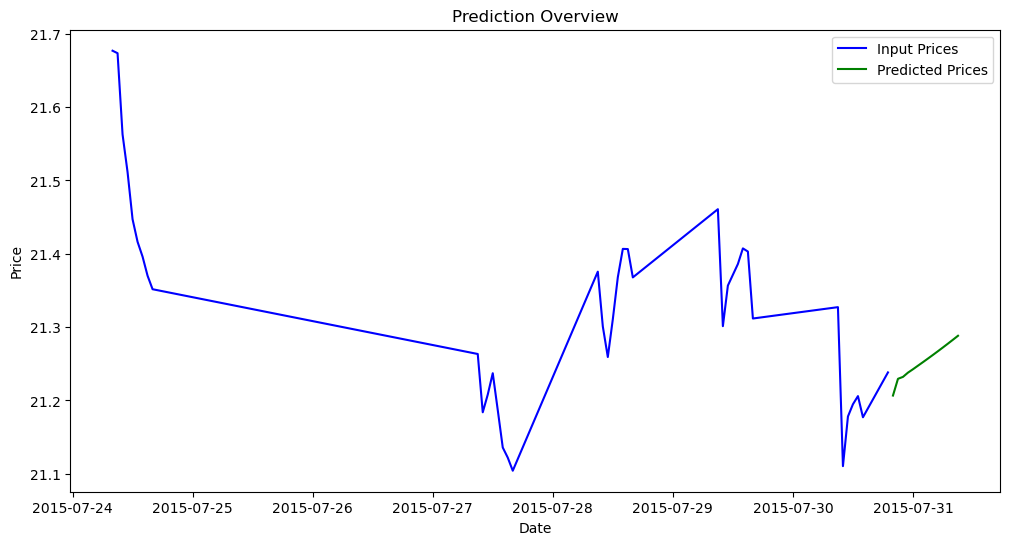

In [32]:
predictor = self.predictor_instances[0]
input = self.get_current_predictor_input(predictor)

prices, dates = predictor.predict(input)
potential = (prices[-1] / input.iloc[-1] - 1).item()

In [25]:
potential

0.0003994251627850165